# Gated Linear Units (GLUs)

```{article-info}
:avatar: https://avatars.githubusercontent.com/u/25820201?v=4
:avatar-link: https://github.com/PhotonicGluon/
:author: "[Ryan Kan](https://github.com/PhotonicGluon/)"
:date: "Jun 19, 2024"
:read-time: "{sub-ref}`wordcount-minutes` min read"
```

In this example, we will explore the use of GLUs, and see how to use Keras-MML's version of GLUs (i.e., `GLUMML`).

:::{note}
For the last part of the notebook, we will be using some plotting utilities. You are free to skip them if you want; otherwise, these additional dependencies are required.
:::

In [1]:
%pip install matplotlib~=3.9.0 seaborn~=0.13.2


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## An Introduction to GLUs

In [_Language Modeling with Gated Convolutional Networks_](https://arxiv.org/pdf/1612.08083) by Dauphin et al., they introduced GLUs, attempting to replace recurrent connections commonly found in Recurrent Neural Networks (RNNs) with gated temporal connections. The idea behind GLUs is simple: we want the neural network to moderate how much information should flow through a given path, like a logical gate.

Suppose the information that 'wants' to flow through the network is represented by the vector $\mathbf{x}$. We moderate the amount of information that is retained by the network by multiplying $\mathbf{x}$ by a constant, say $\alpha$, that is bounded in the interval $[0, 1]$. In particular, when $\alpha = 0$, no information passes through the network, and when $\alpha = 1$ all the information stored in $\mathbf{x}$ passes through.

Now we want the network to also learn how much information to flow through the network, i.e. we want the network to also learn this proposed coefficient $\alpha$. To do so, we could use a `Dense` layer to learn $\alpha$, but we need to make sure that the values produced from this step stay in the interval $[0, 1]$. That's why Dauphin et al. proposes applying the sigmoid activation to this particular layer, in order to bound the coefficient within $[0, 1]$.

In the aforementioned paper, the hidden layers are calculated using
$$
h_l(\mathbf{x}) = (\mathbf{x}\mathbf{W} + \mathbf{b}) \otimes \sigma\left(\mathbf{x}\mathbf{V} + \mathbf{c}\right)
$$
where $\mathbf{x}$ is the input of the layer $h_l$, the matrices $\mathbf{W}, \mathbf{V}$ are weights to be learned by the network, $\mathbf{b}, \mathbf{c}$ are bias vectors that are to also be learned by the network, $\sigma$ is the sigmoid function, and $\otimes$ is the element-wise product between matrices.

Of course, there's no reason why we are restricting ourselves to the sigmoid activation function. In [_GLU Variants Improve Transformer_](https://arxiv.org/pdf/2002.05202) by Shazeer, they propose alternative activation functions, creating other GLU variants:
$$
\begin{align*}
    \mathrm{ReGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}) &= \max\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})\\
    \mathrm{GEGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}) &= \mathrm{GELU}\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})\\
    \mathrm{SwiGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}, \beta) &= \mathrm{Swish}_\beta\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})\\
    \mathrm{SeGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}) &= \mathrm{SELU}\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})
\end{align*}
$$

:::{note}
The $\mathrm{Swish}_1$ activation function (where $\beta = 1$) is equivalent to the $\mathrm{SiLU}$ (Sigmoid Linear Unit) activation function.
:::

## A Simple Example With GLUs

To demonstrate the use of GLUs, we make a simple dataset with the following rules.

1. Each feature vector is a 5-dimensional vector. For example, `[1, 0, 1, 0, 1]`.
2. If the first and third entries sum to at least 1, the output will be the input divided by 2. For example, `[1, 0, 1, 0, 1]` becomes `[0.5, 0, 0.5, 0., 0.5]`.
3. Otherwise the output will all be zeroes. For example `[0, 1, 0, 1, 0]` becomes `[0, 0, 0, 0, 0]`.

We create a dataset of 10000 entries.

In [2]:
import numpy as np

np.random.seed(42)  # For reproducibility

In [3]:
X = np.random.uniform(low=0, size=(10000, 5))

y = np.zeros_like(X)
condition = X[:, 0] + X[:, 2] >= 1
indices = np.where(condition)
y[indices] = X[indices] * 0.5

In [4]:
print(X[:5])
print(y[:5])

[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
 [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
 [0.02058449 0.96990985 0.83244264 0.21233911 0.18182497]
 [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
 [0.61185289 0.13949386 0.29214465 0.36636184 0.45606998]]
[[0.18727006 0.47535715 0.36599697 0.29932924 0.07800932]
 [0.07799726 0.02904181 0.43308807 0.30055751 0.35403629]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


We use a train-test split of 9:1.

In [5]:
train_data = X[:9000], y[:9000]
test_data = X[9000:], y[9000:]

The model that we will use is the traditional GLU model with the sigmoid activation function.

In [6]:
import keras

import keras_mml

2024-06-25 03:00:04.993881: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 03:00:04.996054: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 03:00:05.024675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 03:00:05.726507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.GLUMML(32, activation="sigmoid"),
        keras.layers.Dense(5)
    ], 
    name="GLU-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "GLU-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ glumml (GLUMML)                 │ (None, 32)             │        11,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,461 (44.77 KB)

 Trainable params: 11,461 (44.77 KB)

 Non-trainable params: 0 (0.00 B)

We define a callback to print the training output once every 10 epochs. This is to reduce clutter on the screen.

In [8]:
class print_training_results_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if int(epoch) % 10 == 0:
            print(
                f"Epoch: {epoch:>3}"
                + f" | loss: {logs['loss']:.5f}"
                + f" | mae: {logs['mae']:.5f}"
                + f" | val_loss: {logs['val_loss']:.5f}"
                + f" | val_mae: {logs['val_mae']:.5f}"
            )


Now we can train the model. We train it for 100 epochs using a batch size of 256.

In [9]:
NUM_EPOCHS = 100
BATCH_SIZE = 256

In [10]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)

Epoch:   0 | loss: 0.03405 | mae: 0.14737 | val_loss: 0.02811 | val_mae: 0.15123
Epoch:  10 | loss: 0.01461 | mae: 0.09357 | val_loss: 0.01411 | val_mae: 0.09278
Epoch:  20 | loss: 0.01438 | mae: 0.09166 | val_loss: 0.01437 | val_mae: 0.09324
Epoch:  30 | loss: 0.01405 | mae: 0.08971 | val_loss: 0.01388 | val_mae: 0.08902
Epoch:  40 | loss: 0.01395 | mae: 0.08884 | val_loss: 0.01311 | val_mae: 0.08603
Epoch:  50 | loss: 0.01391 | mae: 0.08841 | val_loss: 0.01363 | val_mae: 0.08741
Epoch:  60 | loss: 0.01392 | mae: 0.08811 | val_loss: 0.01305 | val_mae: 0.08547
Epoch:  70 | loss: 0.01375 | mae: 0.08711 | val_loss: 0.01300 | val_mae: 0.08499
Epoch:  80 | loss: 0.01387 | mae: 0.08725 | val_loss: 0.01290 | val_mae: 0.08477
Epoch:  90 | loss: 0.01370 | mae: 0.08639 | val_loss: 0.01351 | val_mae: 0.08611


In [11]:
test_mse, test_mae = model.evaluate(test_data[0], test_data[1])
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0124 - mae: 0.0819
Test MSE: 0.01287087518721819
Test MAE: 0.08368378132581711


Let's save the record of validation losses for later, so we can make a comparison between different GLU variants.

In [12]:
validation_losses = {}
validation_losses["GLU"] = history.history["val_loss"]

### Other GLU Variants

Let's also try out the `GLUMML` layer on different GLU variants.

In [13]:
VARIANT_MAP = {
    "Bilinear": "linear",
    "GEGLU": "gelu",
    "ReGLU": "relu",
    "SwiGLU": "silu",  # Silu is the same as Swish when beta = 1
    "SeGLU": "selu"
}

In [14]:
def train_variant(variant_name):
    print(f" {variant_name} ".center(50, "="))
    activation_func = VARIANT_MAP[variant_name]
    
    model = keras.Sequential(
        layers=[
            keras.layers.Input(shape=(5,)),
            keras_mml.layers.GLUMML(32, activation=activation_func),
            keras.layers.Dense(5)
        ], 
        name=f"{variant_name}-Model"
    )
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )
    
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data=test_data,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[print_training_results_Callback()]
    )
    
    validation_losses[variant_name] = history.history["val_loss"]
    print()

In [15]:
for variant in VARIANT_MAP:
    train_variant(variant)

==================== Bilinear ====================
Epoch:   0 | loss: 0.03370 | mae: 0.14422 | val_loss: 0.02658 | val_mae: 0.14571
Epoch:  10 | loss: 0.01266 | mae: 0.07863 | val_loss: 0.01249 | val_mae: 0.07699
Epoch:  20 | loss: 0.01230 | mae: 0.07588 | val_loss: 0.01169 | val_mae: 0.07430
Epoch:  30 | loss: 0.01221 | mae: 0.07551 | val_loss: 0.01163 | val_mae: 0.07511
Epoch:  40 | loss: 0.01211 | mae: 0.07475 | val_loss: 0.01194 | val_mae: 0.07606
Epoch:  50 | loss: 0.01209 | mae: 0.07459 | val_loss: 0.01199 | val_mae: 0.07541
Epoch:  60 | loss: 0.01200 | mae: 0.07439 | val_loss: 0.01158 | val_mae: 0.07330
Epoch:  70 | loss: 0.01192 | mae: 0.07400 | val_loss: 0.01133 | val_mae: 0.07218
Epoch:  80 | loss: 0.01197 | mae: 0.07416 | val_loss: 0.01116 | val_mae: 0.07150
Epoch:  90 | loss: 0.01188 | mae: 0.07413 | val_loss: 0.01115 | val_mae: 0.07171

===================== GEGLU ======================
Epoch:   0 | loss: 0.03455 | mae: 0.14384 | val_loss: 0.02646 | val_mae: 0.14400
Epoch:

## Comparison Models

Let's also define two comparison models to assess against the GLU models.

The first will be a simple MLP that uses a $\mathrm{Sigmoid}$ activation in the middle layer.

In [16]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.DenseMML(32),
        keras_mml.layers.DenseMML(256, activation="sigmoid"),
        keras_mml.layers.DenseMML(32),
        keras.layers.Dense(5)
    ], 
    name="Dense-With-Sigmoid-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "Dense-With-Sigmoid-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_mml_12 (DenseMML)         │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_13 (DenseMML)         │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_14 (DenseMML)         │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,029 (66.52 KB)

 Trainable params: 17,029 (66.52 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)
validation_losses["Dense-With-Sigmoid"] = history.history["val_loss"]

Epoch:   0 | loss: 0.03580 | mae: 0.14715 | val_loss: 0.02941 | val_mae: 0.15550
Epoch:  10 | loss: 0.02913 | mae: 0.15220 | val_loss: 0.02877 | val_mae: 0.15167
Epoch:  20 | loss: 0.02187 | mae: 0.11718 | val_loss: 0.02164 | val_mae: 0.12403
Epoch:  30 | loss: 0.01942 | mae: 0.10809 | val_loss: 0.01865 | val_mae: 0.10386
Epoch:  40 | loss: 0.01838 | mae: 0.10359 | val_loss: 0.01786 | val_mae: 0.10429
Epoch:  50 | loss: 0.01804 | mae: 0.10337 | val_loss: 0.01782 | val_mae: 0.09880
Epoch:  60 | loss: 0.01729 | mae: 0.09994 | val_loss: 0.01760 | val_mae: 0.10598
Epoch:  70 | loss: 0.01699 | mae: 0.09896 | val_loss: 0.01600 | val_mae: 0.09559
Epoch:  80 | loss: 0.01694 | mae: 0.09897 | val_loss: 0.01628 | val_mae: 0.09480
Epoch:  90 | loss: 0.01679 | mae: 0.09835 | val_loss: 0.01580 | val_mae: 0.09481


The second is similar to the first, but instead of $\mathrm{Sigmoid}$ we will use $\mathrm{ReLU}$.

In [18]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.DenseMML(32),
        keras_mml.layers.DenseMML(256, activation="relu"),
        keras_mml.layers.DenseMML(32),
        keras.layers.Dense(5)
    ], 
    name="Dense-With-ReLU-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "Dense-With-ReLU-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_mml_15 (DenseMML)         │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_16 (DenseMML)         │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_17 (DenseMML)         │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,029 (66.52 KB)

 Trainable params: 17,029 (66.52 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)
validation_losses["Dense-With-ReLU"] = history.history["val_loss"]

Epoch:   0 | loss: 0.03433 | mae: 0.14594 | val_loss: 0.02808 | val_mae: 0.15051
Epoch:  10 | loss: 0.01221 | mae: 0.07438 | val_loss: 0.01189 | val_mae: 0.07238
Epoch:  20 | loss: 0.01136 | mae: 0.06882 | val_loss: 0.01094 | val_mae: 0.06790
Epoch:  30 | loss: 0.01121 | mae: 0.06837 | val_loss: 0.01137 | val_mae: 0.07015
Epoch:  40 | loss: 0.01102 | mae: 0.06781 | val_loss: 0.01150 | val_mae: 0.06923
Epoch:  50 | loss: 0.01106 | mae: 0.06671 | val_loss: 0.01035 | val_mae: 0.06429
Epoch:  60 | loss: 0.01097 | mae: 0.06702 | val_loss: 0.01060 | val_mae: 0.06422
Epoch:  70 | loss: 0.01093 | mae: 0.06614 | val_loss: 0.01052 | val_mae: 0.06362
Epoch:  80 | loss: 0.01080 | mae: 0.06583 | val_loss: 0.01026 | val_mae: 0.06258
Epoch:  90 | loss: 0.01074 | mae: 0.06534 | val_loss: 0.01042 | val_mae: 0.06385


## Plotting Losses

Let's plot the validation losses over time.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

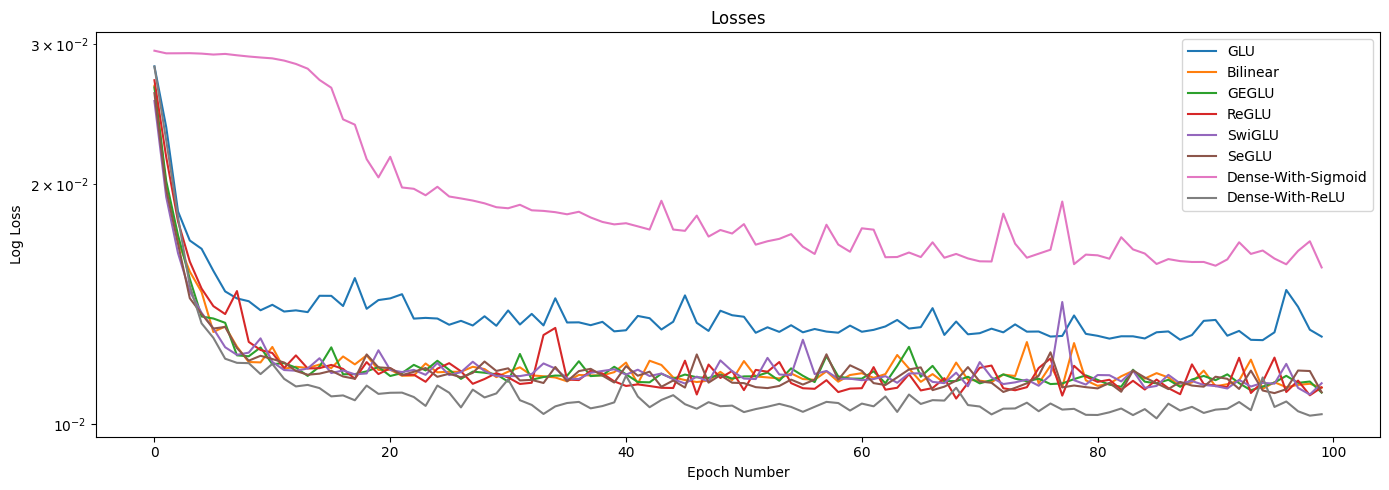

In [21]:
plt.figure(figsize=(14, 5), dpi=100)

for variant in validation_losses: 
    sns.lineplot(validation_losses[variant], label=variant)

plt.legend()
plt.yscale("log")
plt.ylabel("Log Loss")
plt.xlabel("Epoch Number")
plt.title("Losses")
plt.tight_layout()

We can't really see the losses after epoch 20, so let's zoom into that part specifically. Also, `Dense-With-Sigmoid` performs very poorly, so let's exclude that from our analysis below. 

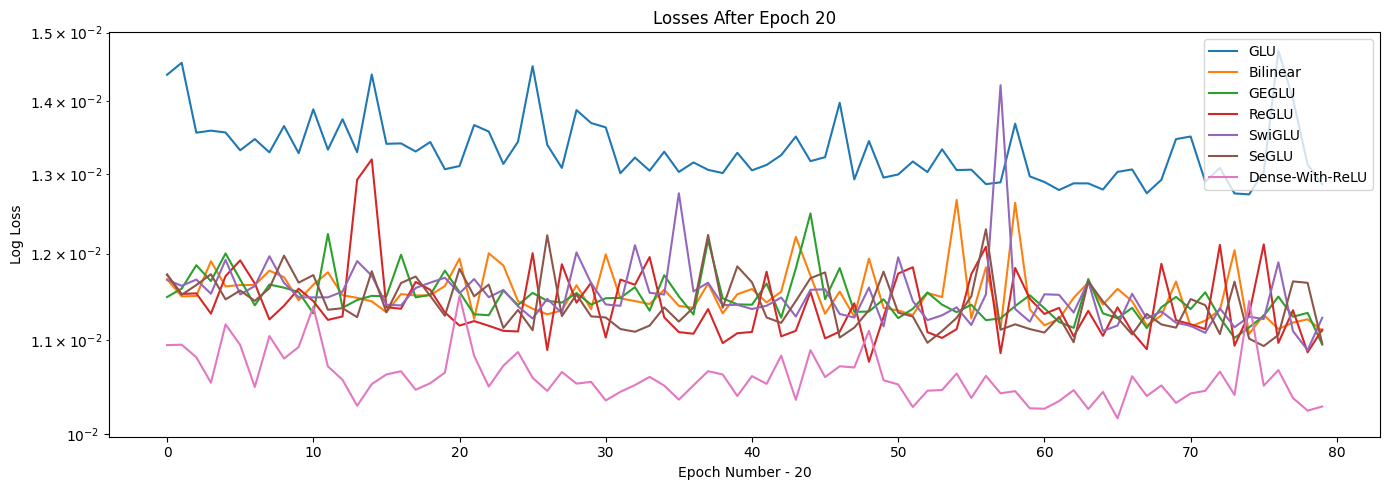

In [22]:
plt.figure(figsize=(14, 5), dpi=100)

for variant in validation_losses:
    if variant == "Dense-With-Sigmoid":
        continue
    sns.lineplot(validation_losses[variant][20:], label=variant)

plt.legend()
plt.yscale("log")
plt.ylabel("Log Loss")
plt.xlabel("Epoch Number - 20")
plt.title("Losses After Epoch 20")
plt.tight_layout()

## Conclusion

From the charts above, we can conclude that all the different models seem to stabilize pretty quickly. However, it is important to note that this is just a toy example, and that GLUs may have a different performance on real datasets. It is thus important to assess all different kinds of architectures before deciding on one.